In [3]:
%load_ext autoreload

%autoreload 2

## Preprocessing Data

### Show a file

Samplerate:  32000  | OGSamplerate:  32000
Samplerate:  32000  | OGSamplerate:  44100
resampling
Clean audio: 


Noisy audio: 


Recreated clean audio: 
Samplerate:  32000


Recreated decoded clean audio: 
Samplerate:  32000


Recreated clean audio with wav2world: 
Samplerate:  32000


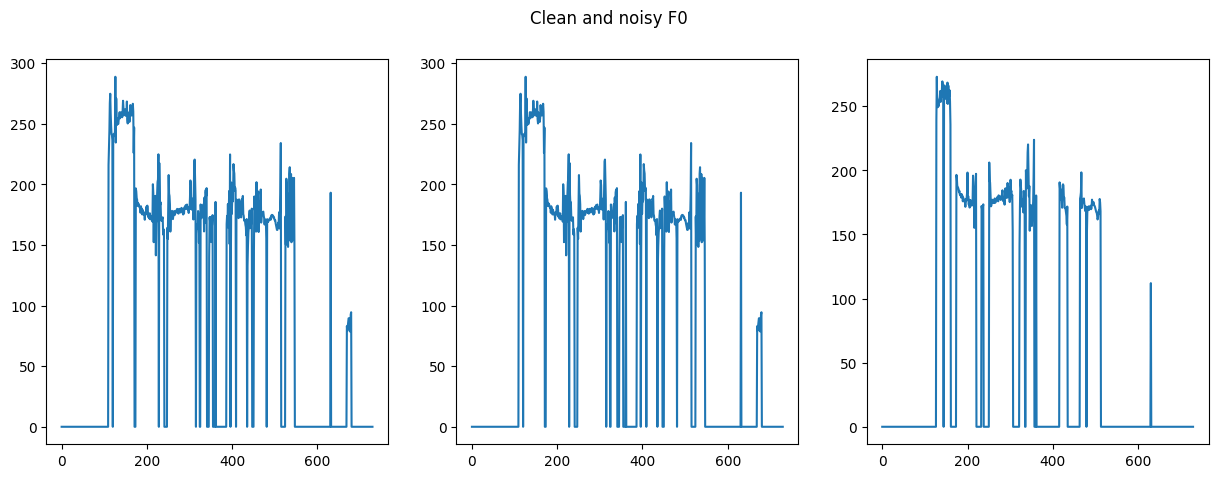

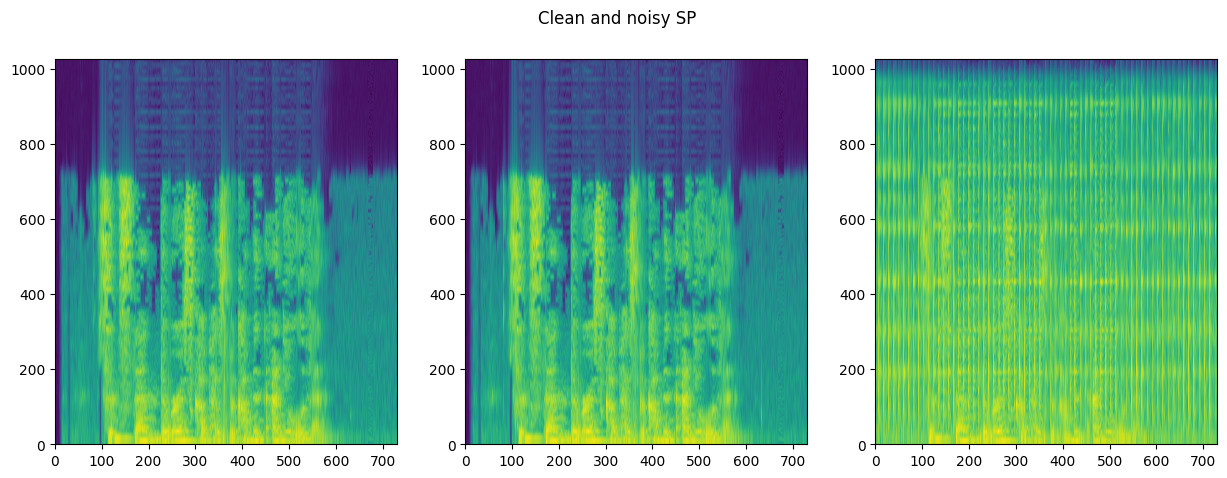

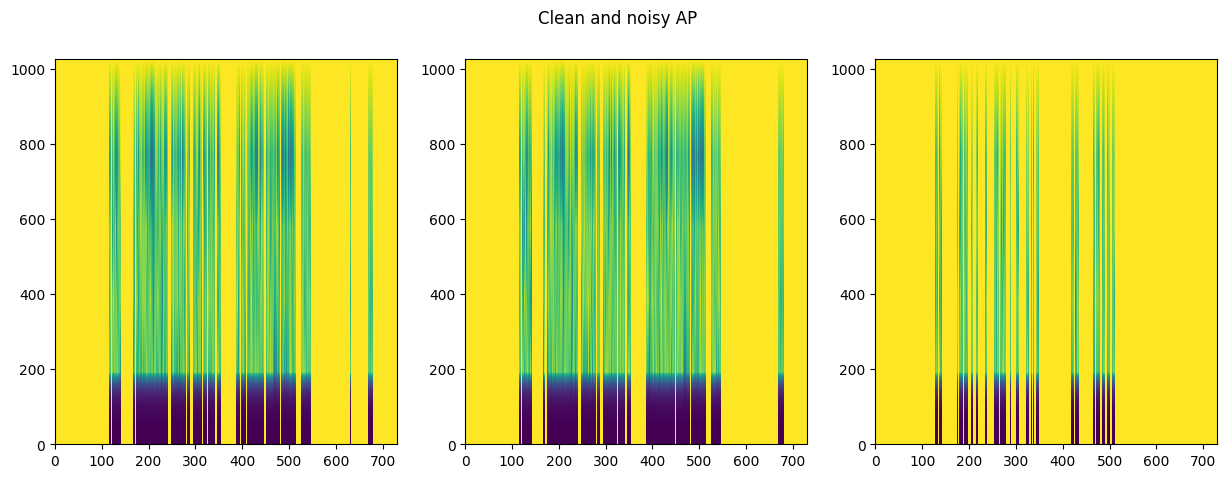

In [1]:
from preprocess import process_wav, decode_harmonic
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import IPython
import numpy as np
import pyworld as pw
import soundfile as sf

cleanvoice = "G:/Projects/2022-2023/ConvDenoiser/dataset/voice/common_voice_en_34919893.mp3"
ambience = "G:/Projects/2022-2023/ConvDenoiser/dataset/soloambience/105029-7-1-9.wav"
plotwidth = 15
plotheight = 5

outputs = process_wav((cleanvoice, ambience))
f0 = outputs[0]
sp = outputs[1]
code_sp = outputs[2]
ap = outputs[3]
code_ap = outputs[4]
f0c = outputs[5]
spc = outputs[6]
code_spc = outputs[7]
apc = outputs[8]
code_apc = outputs[9]
cAudioSamples = outputs[10]
samplerate = outputs[11]
nAudioSamples = outputs[13]


print("Clean audio: ")
IPython.display.display(IPython.display.Audio(cAudioSamples, rate=samplerate))

print("Noisy audio: ")
IPython.display.display(IPython.display.Audio(nAudioSamples, rate=samplerate))

print("Recreated clean audio: ")
print("Samplerate: ", samplerate)
IPython.display.display(IPython.display.Audio(pw.synthesize(f0c, spc, apc, samplerate), rate=samplerate))

print("Recreated decoded clean audio: ")
print("Samplerate: ", samplerate)
IPython.display.display(IPython.display.Audio(pw.synthesize(f0c, decode_harmonic(code_spc, 2048), apc, samplerate), rate=samplerate))

print('Recreated clean audio with wav2world: ')
data, fs = sf.read(cleanvoice)
pf0, psp, pap = pw.wav2world(data, fs)
print("Samplerate: ", fs)
IPython.display.display(IPython.display.Audio(pw.synthesize(pf0, psp, pap, fs), rate=fs))
# Show F0
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(plotwidth, plotheight))
fig.suptitle("Clean and noisy F0")
ax1.plot(pf0)
ax2.plot(f0c)
ax3.plot(f0)
plt.show()
# Show SP Graphs
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(plotwidth, plotheight))
fig.suptitle("Clean and noisy SP")
ax1.pcolormesh(np.ndarray.transpose(psp, (1,0)), norm=LogNorm())
ax2.pcolormesh(np.ndarray.transpose(spc, (1,0)), norm=LogNorm())
ax3.pcolormesh(np.ndarray.transpose(sp, (1,0)), norm=LogNorm())
plt.show()
# Show coded SP Graphs
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(plotwidth, plotheight))
fig.suptitle("Clean and noisy AP")
ax1.pcolormesh(np.ndarray.transpose(pap, (1,0)))
ax2.pcolormesh(np.ndarray.transpose(apc, (1,0)))
ax3.pcolormesh(np.ndarray.transpose(ap, (1,0)))

plt.show()

### Preprocess a bunch of files

In [1]:
from preprocess import startProcessing

voicefolder = "H:/Downloads/DS_10283_1942/clean_trainset_wav/"
noisefolder = "G:/Projects/2022-2023/ConvDenoiser/dataset/ambience/"
exportfolder = "G:/Projects/2022-2023/ConvDenoiser/dataset/output5/"
savepathy = ""

startProcessing(savepathy, voicefolder, noisefolder, exportfolder, 'All')

[['H:/Downloads/DS_10283_1942/clean_trainset_wav/p226_168.wav', 'G:/Projects/2022-2023/ConvDenoiser/dataset/ambience/157866-8-0-23.wav'], ['H:/Downloads/DS_10283_1942/clean_trainset_wav/p226_086.wav', 'G:/Projects/2022-2023/ConvDenoiser/dataset/ambience/137815-4-0-2.wav'], ['H:/Downloads/DS_10283_1942/clean_trainset_wav/p226_294.wav', 'G:/Projects/2022-2023/ConvDenoiser/dataset/ambience/174786-2-0-27.wav'], ['H:/Downloads/DS_10283_1942/clean_trainset_wav/p226_183.wav', 'G:/Projects/2022-2023/ConvDenoiser/dataset/ambience/159726-3-0-0.wav'], ['H:/Downloads/DS_10283_1942/clean_trainset_wav/p226_015.wav', 'G:/Projects/2022-2023/ConvDenoiser/dataset/ambience/105029-7-2-14.wav'], ['H:/Downloads/DS_10283_1942/clean_trainset_wav/p227_090.wav', 'G:/Projects/2022-2023/ConvDenoiser/dataset/ambience/207211-2-0-89.wav'], ['H:/Downloads/DS_10283_1942/clean_trainset_wav/p226_177.wav', 'G:/Projects/2022-2023/ConvDenoiser/dataset/ambience/157866-8-0-6.wav'], ['H:/Downloads/DS_10283_1942/clean_trainset

 22%|██▏       | 442/2000 [07:27<26:19,  1.01s/it]



Enjoy your freshly processed files


## CNN Model

### Setup variables

In [29]:
from SPDenoiser import SPDenoiser, SPDataset
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader

learning_rate = 1e-4
batchsize = 4096
epochs = 100
loss_fn = torch.nn.MSELoss()
device='cuda'

spdenoiser = SPDenoiser(60, 8, device)
spdenoiser.to(device)
spdataset = SPDataset("G:/Projects/2022-2023/ConvDenoiser/dataset/output5/sp/", "G:/Projects/2022-2023/ConvDenoiser/dataset/output5/csp/")
# sptestdataset = SPDataset("H:/Projects/2022-2023/ConvDenoiser/dataset/output/testsp/", "H:/Projects/2022-2023/ConvDenoiser/dataset/output/testcsp/")
spdataloader = DataLoader(spdataset, batch_size=batchsize, shuffle=True)
# sptestdataloader = DataLoader(sptestdataset, batch_size=64, shuffle=True)

optimizer=torch.optim.Adam(spdenoiser.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
lossy = 0
step = 0

Directories:  G:/Projects/2022-2023/ConvDenoiser/dataset/output5/sp/ | G:/Projects/2022-2023/ConvDenoiser/dataset/output5/csp/
Noisy file amount:  4423
Clean file amount:  4423


Loading files to dataset: 100%|████████████████████████████████████████████████████| 4423/4423 [01:16<00:00, 57.83it/s]


torch.Size([1, 60, 8])
torch.Size([1, 60, 1])


ValueError: too many values to unpack (expected 2)

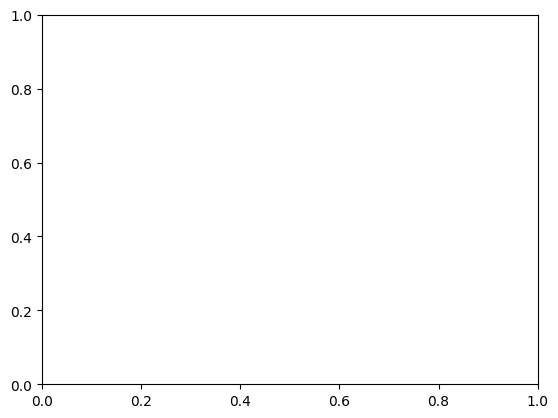

In [30]:
import matplotlib.pyplot as plt

# for x, y in spdataloader:
x, y = next(iter(spdataloader))

print(x[0].size())
print(y[0].size())

plt.pcolormesh(x[0].cpu().detach().numpy())
plt.title("Noisy Coded SP")
plt.show()

plt.pcolormesh(y[0].cpu().detach().numpy())
plt.title("Noisy Coded SP")
plt.show()

# plt.pcolormesh(z[0][0].cpu().detach().numpy())
# plt.title("Noisy Coded SP")
# plt.show()

### Start training

In [31]:
spdenoiser.train()
epochs = 1000
for epoch in range(epochs):
    lossy = 0
    step = 0
    with tqdm(enumerate(spdataloader),desc=f"Training. Epoch: {epoch}. Loss for step {step}: {lossy}") as t:
        for steppy, (x_train,y_train) in t:
            step = steppy
            x_train.double().to(device)
            y_train.double().to(device)

            # print(x_train.size())

            output = spdenoiser(x_train)
            # print("Output: ", output.size())
            # print("Y train: ", y_train.size())

            loss= loss_fn(output.to(device),y_train.to(device))
            lossy += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            t.set_description(f"Training. Epoch: {epoch}. Average loss for step {step}: {lossy / step}")

Training. Epoch: 0. Average loss for step 676: 0.026807289570569992: : 677it [03:33,  3.17it/s]
Training. Epoch: 1. Average loss for step 676: 0.0176481194794178: : 677it [03:19,  3.40it/s]  
Training. Epoch: 2. Average loss for step 676: 0.016932835802435875: : 677it [03:18,  3.41it/s]
Training. Epoch: 3. Average loss for step 676: 0.01648964360356331: : 677it [03:19,  3.39it/s] 
Training. Epoch: 4. Average loss for step 676: 0.016232164576649666: : 677it [03:19,  3.39it/s]
Training. Epoch: 5. Average loss for step 676: 0.016023680567741394: : 677it [03:18,  3.40it/s]
Training. Epoch: 6. Average loss for step 676: 0.01592485047876835: : 677it [03:19,  3.40it/s] 
Training. Epoch: 7. Average loss for step 676: 0.015805266797542572: : 677it [03:19,  3.40it/s]
Training. Epoch: 8. Average loss for step 676: 0.01572636142373085: : 677it [03:18,  3.41it/s] 
Training. Epoch: 9. Average loss for step 676: 0.01564340852200985: : 677it [03:19,  3.40it/s] 
Training. Epoch: 10. Average loss for st

KeyboardInterrupt: 

### Save Model

In [32]:
torch.save(spdenoiser.state_dict(), "./FinalConvModel")

### Test Model

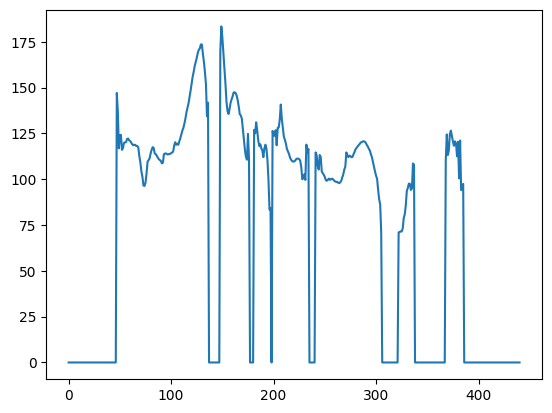

In [33]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from WavenetDenoiser import SPWavenetDenoiser
from util import sample_from_CGM
import pyworld as pw
import soundfile as sf
import IPython
from preprocess import decode_harmonic, process_wav

x, fs = sf.read("G:/Projects/2022-2023/Butternut Box/Kieskeurig/Clip 5.wav")
f0, sp, ap = pw.wav2world(x, fs)

plt.plot(f0)
plt.show()

Testfile shape:  (441, 60)
Coded ap shape: (1037, 4)
ap shape: (1037, 1025)
(1, 60)
[]


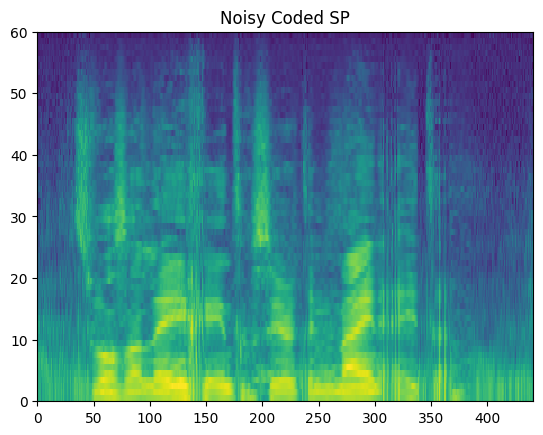

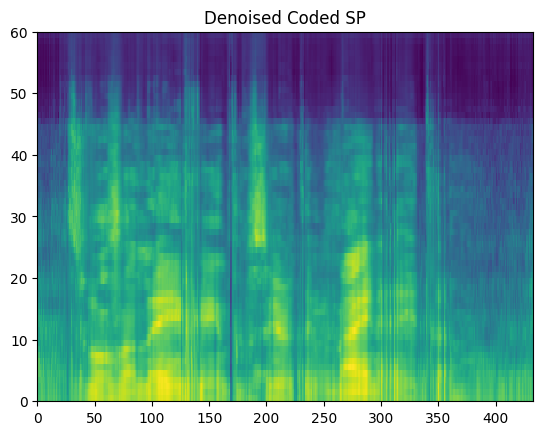

In [40]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from SPDenoiser import SPDenoiser
from preprocess import code_harmonic

def normalize1(noisy_file):
    noisy_file = torch.from_numpy(noisy_file)

    noisy_min = torch.min(noisy_file)

    noisy_file = noisy_file - noisy_min

    noisy_max = torch.max(noisy_file)

    noisy_file = noisy_file / noisy_max

    noisy_file = noisy_file.cpu().detach().numpy()   

    return noisy_file, noisy_min, noisy_max

testfile = code_harmonic(sp.astype(np.float32), 60)
realcleanfile = np.load("G:/Projects/2022-2023/ConvDenoiser/dataset/output4/csp/common_voice_en_34925222.mp3_sp.npy").astype(np.float32)
apc = np.load("G:/Projects/2022-2023/ConvDenoiser/dataset/output4/cap2/common_voice_en_34925222.mp3_ap.npy")
coded_apc = np.load("G:/Projects/2022-2023/ConvDenoiser/dataset/output4/cap/common_voice_en_34925222.mp3_ap.npy")
f0c = np.load("G:/Projects/2022-2023/ConvDenoiser/dataset/output4/f0c/common_voice_en_34925222.mp3_f0.npy")
spc = np.load("G:/Projects/2022-2023/ConvDenoiser/dataset/output4/csp2/common_voice_en_34925222.mp3_sp.npy")
print('Testfile shape: ', np.shape(testfile))
# testfile = torch.nn.functional.normalize(torch.from_numpy(testfile))
# testfile = testfile.cpu().detach().numpy()
print('Coded ap shape:', np.shape(coded_apc))

print('ap shape:', np.shape(apc))

# model = SPDenoiser(60, 8, 'cuda')
# model.load_state_dict(torch.load("./15EpochModelDropout"))

realcleanfile = torch.nn.functional.normalize(torch.from_numpy(realcleanfile))
realcleanfile = realcleanfile.cpu().detach().numpy()
testsamples = []

testfile, minny, maxy = normalize1(testfile)
spdenoiser.eval()

cleansamples = []
i = 0
while i < len(testfile) - 8:
    testsamples.append(testfile[i:i+8])
    cleansamples.append(realcleanfile[i:i+8])
    i += 1

print(np.shape(cleansamples[0][-1:]))
cleanfile = np.zeros((0,60))
realclean = np.zeros((0,60))
print(cleanfile)
k = 0

# smallsample = torch.from_numpy(testsamples[500]).transpose(0,1).unsqueeze(0).unsqueeze(0)
# smallsample = smallsample.squeeze(0).squeeze(0).transpose(0,1).cpu().detach().numpy()
# plt.pcolormesh(np.ndarray.transpose(smallsample, (1,0)))
# plt.title("Noisy Coded SP")
# plt.show()

# clean = torch.from_numpy(smallsample)[:, -1:]
# clean = clean.cpu().detach().numpy()
# plt.pcolormesh(np.ndarray.transpose(clean, (1,0)))
# plt.title("Noisy Coded SP")
# plt.show()

for sample in testsamples:
    sample = torch.from_numpy(sample).transpose(0,1).unsqueeze(0).unsqueeze(0)
    output = spdenoiser(sample.type(torch.FloatTensor))
    # print(output.size())
    output = output.squeeze(0).squeeze(0).transpose(0,1).cpu().detach().numpy()
    realclean = np.concatenate((realclean, cleansamples[k][-1:]), axis=0)
    # print('Output size: ', np.shape(output))
    cleanfile = np.concatenate((cleanfile, output), axis=0)
    # print('Cleanfile shape: ', np.shape(cleanfile))
    k += 1

cleanfile = cleanfile * maxy.cpu().detach().numpy()
cleanfile = cleanfile + minny.cpu().detach().numpy()
# newinput = torch.squeeze(noisy, dim=0)
# print(newinput.size())

plt.pcolormesh(np.ndarray.transpose(testfile, (1,0)))
plt.title("Noisy Coded SP")
plt.show()

plt.pcolormesh(np.ndarray.transpose(cleanfile, (1,0)))
plt.title("Denoised Coded SP")
plt.show()

# plt.pcolormesh(np.ndarray.transpose(realclean, (1,0)))
# plt.title("Stitched clean Coded SP")
# plt.show()

# plt.pcolormesh(np.ndarray.transpose(realcleanfile,(1,0)))
# plt.show()

# print(cleanfile)
# print(testfile)

### Export as audio file using original clean aperiodicity and f0

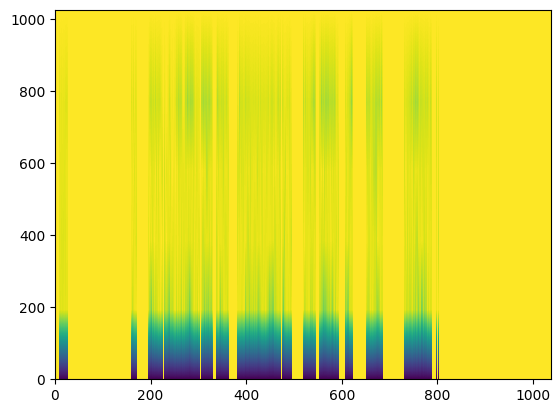

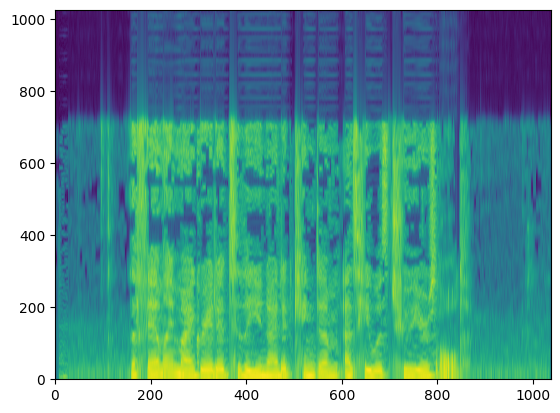

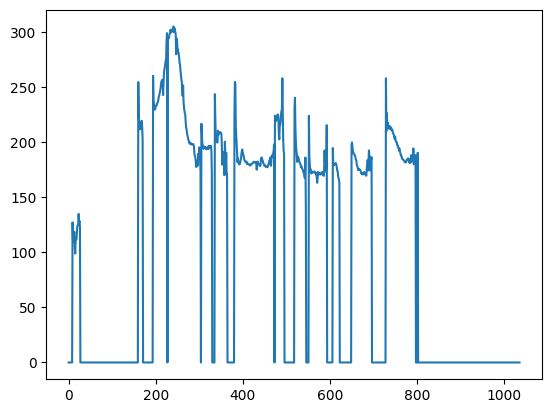

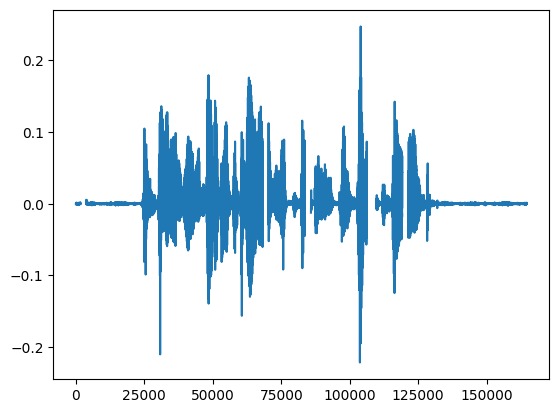

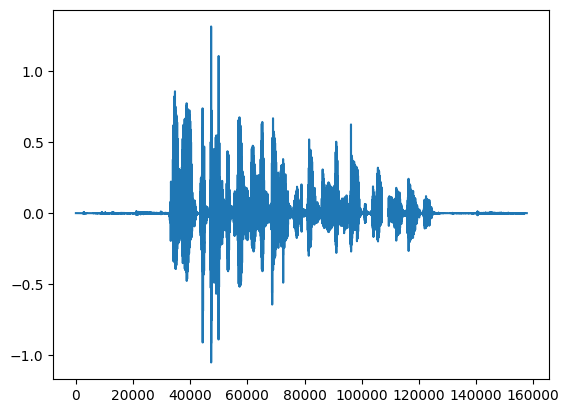

In [5]:
from preprocess import decode_harmonic
import pyworld as pw
# import IPython.display as ipd
import soundfile as sf
import IPython
from matplotlib.colors import LogNorm

# ogspc = np.load("H:/Projects/2022-2023/ConvDenoiser/dataset/output2/csp2/common_voice_en_34919211.mp3_sp.npy")
# print(np.shape(apc))
plt.pcolormesh(np.ndarray.transpose(apc, (1,0)),norm=LogNorm())
plt.show()

# swag = np.ascontiguousarray(decode_harmonic(cleanfile, 2048))
plt.pcolormesh(np.ndarray.transpose(spc, (1,0)),norm=LogNorm())
plt.show()

plt.plot(f0c)
plt.show()


y2 = pw.synthesize(f0c, spc, apc, 32000)

# x, sr = sf.read("G:/Projects/2022-2023/ConvDenoiser/dataset/voice/common_voice_en_34919212.mp3")
x, sr = sf.read("G:/Projects/2022-2023/ConvDenoiser/dataset/voice/common_voice_en_34919177.mp3")
f02, sp2, ap2 = pw.wav2world(x, sr)
y3 = pw.synthesize(f02, sp2, ap2, sr)

y = pw.synthesize(np.ascontiguousarray(f0c[0:1029]), np.ascontiguousarray(decode_harmonic(cleanfile, 2048)), np.ascontiguousarray(apc[0:1029]), 32000)

plt.plot(y)
plt.show()

plt.plot(y3)
plt.show()
y = y

# sound = ipd.Audio(y, rate = 44100, autoplay=True)
IPython.display.display(IPython.display.Audio(y, rate=32000))
IPython.display.display(IPython.display.Audio(y2, rate=32000))
IPython.display.display(IPython.display.Audio(y3, rate=32000))
sf.write("./ckaas.wav", y, 32000)
# sf.write("./akaas2.wav", y2, 32000)
# sf.write("./akaas3.wav", y3, 32000)
# print(sound)